In [1]:
from pyspark.sql import SparkSession

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("HDFS Parquet Read") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .getOrCreate()
# HDFS에서 Parquet 파일 읽기
df = spark.read.parquet("hdfs:///youtube_data/*.parquet")
df.count()
df.show()

25/02/11 15:53:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/11 15:53:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/02/11 15:53:07 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
                                                                                

+-----------+---------------------------------+--------------------+------------+-----------------------------------+----------+--------------------+
|   video_id|                            title|        publish_date|channel_name|                            comment|like_count|comment_publish_date|
+-----------+---------------------------------+--------------------+------------+-----------------------------------+----------+--------------------+
|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-15T11:00:36Z|   ITSub잇섭|      이분 지금 뭐쓰시나요 ㅋㅋㅋㅋ|         0|2025-02-05T20:04:57Z|
|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-15T11:00:36Z|   ITSub잇섭|     저도 14프로에서 16일반으로 ...|         0|2025-02-04T00:49:39Z|
|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-15T11:00:36Z|   ITSub잇섭|       9:15 똥믈리에 PD님이랑 두...|         0|2025-01-31T11:02:31Z|
|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-15T11:00:36Z|   ITSub잇섭|   갤럭시를 쓰면 생활,삶의 질이 ...|         0|2025-01-30T07:40:59Z|
|cdiVvaq6UO4|무조건 아이폰 프로만 고집했던 ...|2024-09-15T11:00:36

## 리뷰 형태 탐색

In [2]:
# 스키마 확인
df.printSchema()

# 기본 통계 정보 확인
df.describe().show()


root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- channel_name: string (nullable = true)
 |-- comment: string (nullable = true)
 |-- like_count: long (nullable = true)
 |-- comment_publish_date: string (nullable = true)



[Stage 4:============================================>              (3 + 1) / 4]

+-------+-----------+-----------------------------+--------------------+------------+--------------------+-----------------+--------------------+
|summary|   video_id|                        title|        publish_date|channel_name|             comment|       like_count|comment_publish_date|
+-------+-----------+-----------------------------+--------------------+------------+--------------------+-----------------+--------------------+
|  count|     197418|                       197418|              197418|      197418|              197418|           197418|              197418|
|   mean|       null|                         null|                null|        null|   2.3298615284375E8|5.929945597665866|                null|
| stddev|       null|                         null|                null|        null|1.5909295003813276E9|77.72400681248966|                null|
|    min|-lRdNdJ24Z8| #갤럭시S24 #울트라 #블랙 ...|2024-01-17T18:00:19Z|         YTN|                    |                0|2024-01-

In [3]:
# 각 컬럼의 고유값 개수 확인
for col in df.columns:
    print(f"{col}: {df.select(col).distinct().count()} unique values")

video_id: 193 unique values


title: 193 unique values
publish_date: 193 unique values
channel_name: 66 unique values
comment: 90126 unique values
like_count: 536 unique values
comment_publish_date: 90105 unique values


In [5]:
# 결측치 확인
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()



[Stage 29:=============================>                            (2 + 2) / 4]

+--------+-----+------------+------------+-------+----------+--------------------+
|video_id|title|publish_date|channel_name|comment|like_count|comment_publish_date|
+--------+-----+------------+------------+-------+----------+--------------------+
|       0|    0|           0|           0|      0|         0|                   0|
+--------+-----+------------+------------+-------+----------+--------------------+



In [7]:
# 리뷰 내용 확인

from pyspark.sql.functions import length, avg

# 리뷰 길이 통계
df.select(avg(length("comment")).alias("avg_review_length")).show()

# 가장 긴 리뷰와 가장 짧은 리뷰 확인
df.orderBy(length("comment").desc()).select("comment").show(1, truncate=False)
df.orderBy(length("comment").asc()).select("comment").show(1, truncate=False)


+-----------------+
|avg_review_length|
+-----------------+
|47.56988724432423|
+-----------------+



+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [9]:
# 시간 기반 분석
from pyspark.sql.functions import to_date, year, month

# 날짜별 리뷰 수 확인
df.groupBy(to_date("publish_date").alias("date")).count().orderBy("date").show()

# 월별 리뷰 수 확인
df.groupBy(year("publish_date"), month("publish_date")).count().orderBy("year(publish_date)", "month(publish_date)").show()


+----------+-----+
|      date|count|
+----------+-----+
|2024-01-17|  185|
|2024-01-18|  203|
|2024-01-21|  168|
|2024-01-23|  204|
|2024-01-24| 1677|
|2024-01-25| 1874|
|2024-01-26|  350|
|2024-01-27|  489|
|2024-01-28|  480|
|2024-01-30|  554|
|2024-01-31|  952|
|2024-02-05| 2860|
|2024-02-12|  742|
|2024-02-20| 2548|
|2024-02-22|  253|
|2024-02-25|  868|
|2024-02-28| 1596|
|2024-03-07|  191|
|2024-03-12|  166|
|2024-03-16|  175|
+----------+-----+
only showing top 20 rows

+------------------+-------------------+-----+
|year(publish_date)|month(publish_date)|count|
+------------------+-------------------+-----+
|              2024|                  1| 7136|
|              2024|                  2| 8867|
|              2024|                  3|  862|
|              2024|                  4| 3013|
|              2024|                  5| 1898|
|              2024|                  6| 2302|
|              2024|                  7|45327|
|              2024|                  8|14993|
|

In [10]:
# 시각화를 위한 데이터 샘플링 및 Pandas DataFrame으로 변환
pandas_df = df.sample(fraction=0.1, seed=42).toPandas()


/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45843 (\N{HANGUL SYLLABLE DAES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLL

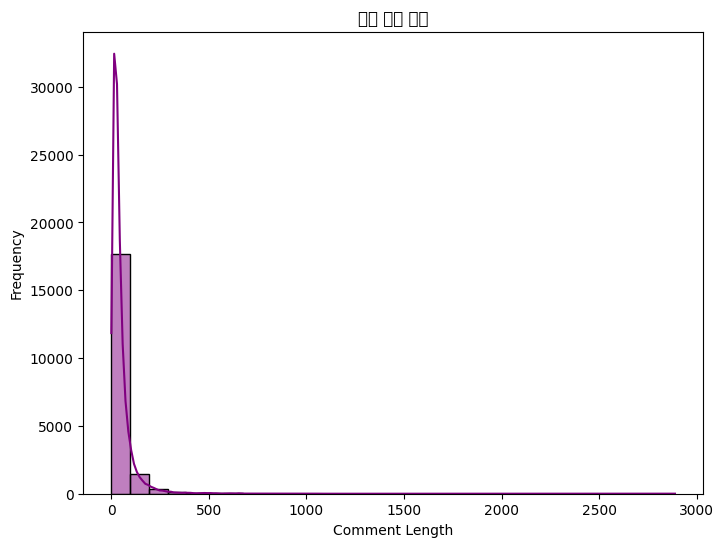

In [12]:
# 리뷰 길이 시각화
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# 리뷰 길이 계산
pandas_df['comment_length'] = pandas_df['comment'].apply(len)

# 히스토그램으로 리뷰 길이 분포 시각화
plt.figure(figsize=(8, 6))
sns.histplot(pandas_df['comment_length'], kde=True, color='purple', bins=30)
plt.title('댓글 길이 분포')
plt.xlabel('Comment Length')
plt.ylabel('Frequency')
plt.show()



/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51339 (\N{HANGUL SYLLABLE JOH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/ubuntu/anaconda3/envs/Project/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54252 (\N{HANGUL SYLLABL

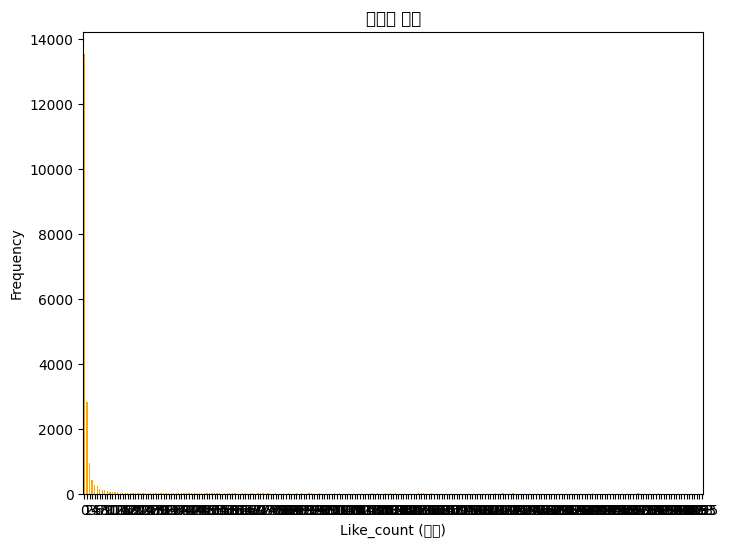

In [13]:
# 영상 좋아요 분포 확인

# 좋아요수별 빈도수 계산 및 정렬
scoring_counts = pandas_df['like_count'].value_counts().sort_index()

# 막대그래프 시각화
plt.figure(figsize=(8, 6))
scoring_counts.plot(kind='bar', color='orange')
plt.title('좋아요 분포')
plt.xlabel('Like_count (점수)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


## 리뷰 내용 탐색

In [14]:
import re
from collections import Counter

# 리뷰 텍스트 데이터 정리 (전처리)
def preprocess_text(text):
    # 소문자로 변환, 특수문자 제거, 숫자 제거
    text = re.sub(r'[^\w\s]', '', text.lower())  # 특수문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    return text

# 리뷰 텍스트에 전처리 적용
pandas_df['cleaned_comment'] = pandas_df['comment'].apply(preprocess_text)


In [15]:
# 단어 빈도 계산

# 모든 리뷰의 단어를 하나의 리스트로 합치기
all_words = pandas_df['cleaned_comment'].str.split().sum()

# 단어 빈도 계산
word_counts = Counter(all_words)

# 상위 10개 단어 출력
most_common_words = word_counts.most_common(10)
print("가장 많이 등장한 단어:")
for word, count in most_common_words:
    print(f"{word}: {count}")


가장 많이 등장한 단어:
너무: 1202
진짜: 1118
더: 1037
폴드: 1018
아이폰: 967
잘: 705
프로: 684
그냥: 673
좀: 669
카메라: 612


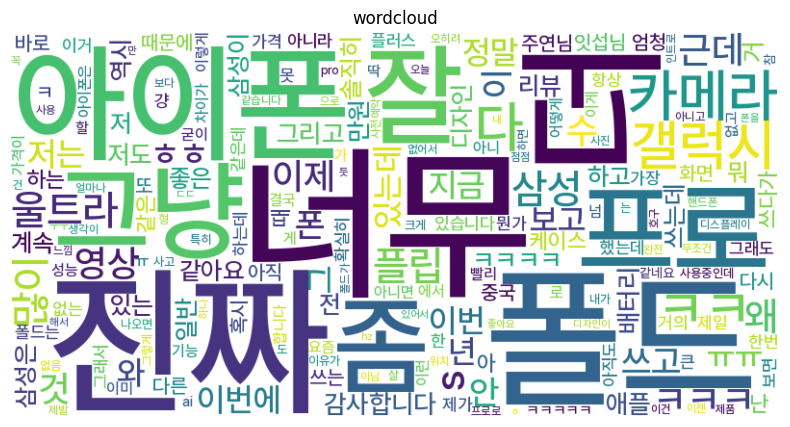

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 한글 폰트 경로
font_path = 'font/Pretendard-Medium.ttf'  

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('wordcloud')
plt.show()


## 데이터 전처리

In [18]:
# 문자열 아닌 데이터 모두 제거
cleaned_comment1 = [review for review in pandas_df['cleaned_comment'] if type(review) is str]
cleaned_comment1

[' 뭐야 잇섭 몸무게 밖에 안 돼 럴',
 '모토글램  아트릭스  아이폰s   화웨이 넥서스 p  아이폰  아이폰 \n웬 종놈처럼 폰을 바꿨네 ',
 '다 필요없고 무거워',
 '아이폰프로 케이스 어떤거 쓰시나요',
 '갤럭시 아이폰 갤럭시 엣지까진 나랑 똑같네 ㅋㅋ 엣지 너무 부시고 싶어서 막 썻던 기억이 너무 쓰레기엿음 ㅋㅋㅋ',
 '예뻤다 처음이자마지막 ',
 '카메라 쓰지도 않는거 빼고 좀 팔면 안됨 언제부터 스마트폰 스펙에 중요점이 카메라가 된거야 안쓰는 사람한테 거진 강매잔아 기본 폰은 hz라 존나 쓰기 짜증나고',
 '프로 쓰는데 무거워서 너무 불편하긴 함 ㅎㅎ',
 '프로와 일반의 성능차이가 필요치 않으면 그냥 구형을 계속 쓰지 신형 살 필요 없는거 아닌가요 요즘 아이폰은 전작 프로랑 신형 일반이랑 ap 동일인데 디자인도 거의 같고',
 '일반에 hz만 있으면 완벽한데',
 'g ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 '진짜 아이폰 갈수록 비싸져서 못써먹겠네여 ㅋ ㅠㅠㅠ',
 '싸고 좋은건 없다 프로맥스 겔울트라s 둘다씀가족용 업무용 굳이 투폰쓰는 가장큰 이유 통화녹음 문제와 지금까지 구매한 애플 제품들이 아까워서지금도 이돈이면 m맥북프로 사지 하면서 계속 m패드 프로 사야되는 이유를 만드는중ㅠㅜ 요번 패드 업데이트가 대박이면 바로살듯사야될사도되는 이유라면서',
 '만원차이면 그냥 프로가는게 나은듯\n술 한두번 안먹으면 될돈임',
 '아이폰 안써본 사람이 자꾸 잇썹 이런 영상 보고 편견 가짐 ㅠㅠ\n미치겠음 ㅠㅠ\n저는 년째 매년 새 아이폰 쓰는 사람인데 제 말은 안들음 ㅋㅋ 하',
 '일반 주사율 올려도 대충 hz 정도 넣겠지\nhz 넣으면 pro 판매량 확 줄어들텐데 일반에다 넣어줄리가 없음',
 '저도 프로 망원카메라에 먼지가 있더군요 아이폰 카메라 특성인지 고스트도 아쉽고',
 '이번 아이폰 일반형 터치 감도가 진짜 뚝뚝 끊김\n자연스럽게 화면이 넘어가지 않고 렉걸린거 마냥 뚝뚝 끊기는게 엄청 거슬림\n마치 자동차로

In [19]:
!pip install konlpy

Defaulting to user installation because normal site-packages is not writeable


In [23]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
#전처리 함수 만들기
def preprocessing(review, okt, remove_stopwords = False, stop_words =[]):
  #함수인자설명
  # review: 전처리할 텍스트
  # okt: okt객체를 반복적으로 생성하지 않고 미리 생성 후 인자로 받음
  # remove_stopword: 불용어를 제거할지 여부 선택. 기본값 False
  # stop_words: 불용어 사전은 사용자가 직접 입력, 기본값 빈 리스트

  # 1. 한글 및 공백 제외한 문자 모두 제거
  review_comment = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',review)
  
  #2. okt 객체를 활용하여 형태소 단어로 나눔
  word_comment = okt.morphs(review_comment,stem=True)

  if remove_stopwords:
    #3. 불용어 제거(선택)
    word_comment = [token for token in word_comment if not token in stop_words]
  return word_comment

In [41]:
# 전체 텍스트 전처리
stop_words = ['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한', '야', '을', '웬', '뭐']
okt = Okt()
clean_comment_list = []

for review in pandas_df['cleaned_comment']:
  # 리뷰가 문자열인 경우만 전처리 진행
  if type(review) == str:
    clean_comment_list.append(preprocessing(review,okt,remove_stopwords=True,stop_words= stop_words))
  else:
    clean_comment_list.append([]) #str이 아닌 행은 빈칸으로 놔두기

clean_comment_list[:4]

[['잇다', '섭', '몸무게', '밖에', '안', '돼다', '럴'],
 ['모토글램', '아트릭스', '아이폰', '화웨이', '넥서스', '아이폰', '아이폰', '종놈', '처럼', '폰', '바꾸다'],
 ['다', '필요없다', '무거워'],
 ['아이폰', '프로', '케이스', '어떻다', '쓸다']]

In [30]:
type(clean_comment_list)

list

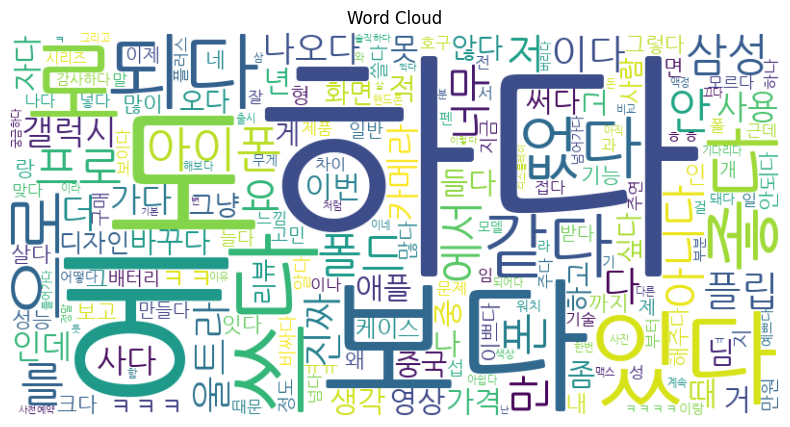

In [42]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.font_manager as fm

# 🔹 시스템 폰트 경로 확인
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # 여기에 있는 폰트로 변경

# 모든 리뷰에서 단어들을 하나의 리스트로 합치기
all_words = [word for review in clean_comment_list for word in review]

# 단어 빈도 계산
clean_comment_counts = Counter(all_words)

# 🔹 줄바꿈과 빈 단어 필터링
filtered_words = {word.replace("\n", ""): count for word, count in clean_comment_counts.items() if word.strip()}

# 워드클라우드 생성
wordcloud = WordCloud(font_path=font_path, width=800, height=400, background_color='white').generate_from_frequencies(filtered_words)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()
